In [1]:
import pykep as pk
import numpy as np
import json
import pickle as pkl

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
import cascade as csc
from copy import deepcopy
from tqdm.notebook import tqdm
import heyoka as hy

# 1 - We import the results of simulation

In [3]:
# These contain the simulation setup data
with open("../../data/debris_simulation_ic.pk", "rb") as file:
    r_ic,v_ic,c_radius,to_satcat,satcat,debris = pkl.load(file)

In [4]:
# This contains the last logged year of simulation
with open("year_19.pk", "rb") as file:
    new_r_ic, new_v_ic, new_c_radius, new_BSTARS, new_to_satcat = pkl.load(file)

In [5]:
# This is the old satcat format (contains the operational status)
satcat_legacy = pk.util.read_satcat("../../data/satcat.txt")

In [6]:
# The log of all decayed satellites
decay_log = np.loadtxt("decay_log.txt", delimiter=",")

In [7]:
# The logg of all collisions
collision_log = np.loadtxt("collision_log.txt", delimiter=",")

# Here we look into the collision log

In [8]:
# To define an average density, we consider the known data for Starlink
starlinkmass=240
starlinksize=2. # (this is from our collisional secion modelling)
# ... and define an average density
avg_density = starlinkmass / (4/3*np.pi*(starlinksize/2)**3)

In [16]:
# We loop in the collision log and explore the collision type
coll_epochs = []
coll_type = []
name1 = []
name2 = []
unavoidable = []
for i,entry in enumerate(collision_log):
    print(f"Years elapsed: {entry[0] / 365.25 : .2f}")
    coll_epochs.append(entry[0] / 365.25)
    # We extract the two satellite ids
    id1 = int(entry[1])
    id2 = int(entry[2])
    r1 = entry[3:6]
    v1 = entry[6:9]
    r2 = entry[9:12]
    v2 = entry[12:15]
    
    # We compute their masses from our average density and their collision radius
    M1 = debris[id1].collision_radius**3*np.pi*4/3 * avg_density
    M2 = debris[id2].collision_radius**3*np.pi*4/3 * avg_density
    # We compute the event type (NASA breakup model)
    Mtarget = max(M1,M2)
    Mprojectile = min(M1,M2)
    vrel = np.linalg.norm(v1-v2)
    E_value = 0.5*Mprojectile*vrel**2/Mtarget/1000
    if E_value > 40:
        f_type = "Fragmentation"
    if E_value < 40:
        f_type = "Collision"
    coll_type.append(f_type)
    # We log stuff on screen
    print(satcat[id1]["OBJECT_NAME"] + f", {debris[id1].collision_radius: .2f} m")
    print(satcat[id2]["OBJECT_NAME"] + f", {debris[id2].collision_radius: .2f} m")
    name1.append(satcat[id1]["OBJECT_NAME"])
    name2.append(satcat[id2]["OBJECT_NAME"])

    print(f"Relative velocity: {vrel/1000:.2f} km/sec")
    print(f"{f_type}: {E_value:.4f} J/g", end='')
    # If at least one of the satellite is operational we mark the collision as avoided (assumes CAS)
    id1 = satcat[id1]["OBJECT_ID"].strip()
    id2 = satcat[id2]["OBJECT_ID"].strip()
    status1 = satcat_legacy[id1].operationstatus
    status2 = satcat_legacy[id2].operationstatus
    if status1=="+" or status2=="+":
        print(" - Avoided", end='')
    else:
        unavoidable.append(i)
    print("\n")

Years elapsed:  0.63
ONEWEB-0040,  2.00 m
FLOCK 4V 22,  0.15 m
Relative velocity: 5.69 km/sec
Collision: 6.8311 J/g - Avoided

Years elapsed:  1.42
SL-8 DEB,  0.06 m
FENGYUN 1C DEB,  0.06 m
Relative velocity: 15.09 km/sec
Fragmentation: 111233.0287 J/g

Years elapsed:  2.69
ONEWEB-0111,  2.00 m
STARLINK-2214,  2.00 m
Relative velocity: 6.42 km/sec
Fragmentation: 20610.3683 J/g - Avoided

Years elapsed:  3.92
OBJECT U,  0.15 m
COSMOS 1818 COOLANT,  0.15 m
Relative velocity: 13.62 km/sec
Fragmentation: 92739.5614 J/g

Years elapsed:  4.53
THORAD AGENA D DEB,  0.11 m
FLOCK 4X 36,  0.55 m
Relative velocity: 14.67 km/sec
Fragmentation: 895.0880 J/g - Avoided

Years elapsed:  4.57
STARLINK-1049,  2.00 m
STARLINK-2475,  2.00 m
Relative velocity: 10.35 km/sec
Fragmentation: 53529.4471 J/g - Avoided

Years elapsed:  5.16
FENGYUN 1C DEB,  0.06 m
COSMOS 1408 DEB,  0.15 m
Relative velocity: 5.33 km/sec
Fragmentation: 848.4143 J/g

Years elapsed:  5.72
KX-09,  0.55 m
SEEKER,  0.15 m
Relative veloci

# We produce some plots on the satellites

<IPython.core.display.Javascript object>


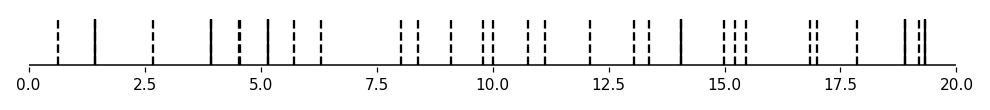

In [73]:
import matplotlib.lines as lin
fig = plt.figure(figsize = (9,1))
ax = plt.axes(frameon=False)
plt.vlines(coll_epochs, 0, 1, linestyles='dashed', color='k')
plt.vlines(np.array(coll_epochs)[unavoidable], 0, 1, color='k')
ax.get_xaxis().tick_bottom()
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim(0,20)
ax.add_artist(lin.Line2D((0, 20), (0, 0), color='black', linewidth=1))
plt.tight_layout()
plt.savefig("coll_freq.png", dpi=300)

In [10]:
el = []
for i in range(len(r_ic)):
    el.append(pk.ic2par(r_ic[i], v_ic[i], pk.MU_EARTH))
el = np.array(el)

el_new = []
for i in range(len(new_r_ic)):
    el_new.append(pk.ic2par(new_r_ic[i], new_v_ic[i], pk.MU_EARTH))
el_new = np.array(el_new)

<IPython.core.display.Javascript object>


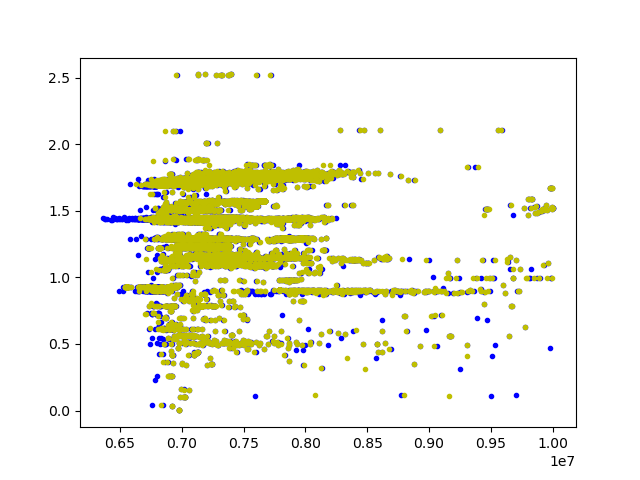

In [11]:
plt.plot(el[:,0], el[:,2], 'b.')
plt.plot(el_new[:,0], el_new[:,2], 'y.')